In [5]:
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sspspace import HexagonalSSPSpace
import nengo
from online_rl_networks import ValueCritic, sparsity_to_x_intercept
from lmu_networks import LMUNetwork_v2, LMUProcess, LMUNetwork
from scipy.special import legendre
import utils.figure_utils as utils

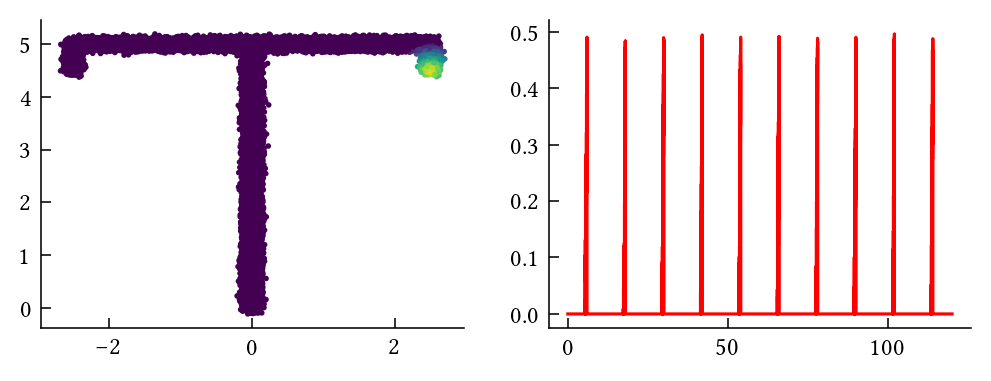

In [10]:
maze_h = 5
maze_w = 5
maze_dh = 0.5

T = 120
dt = 0.001
timesteps = np.arange(0,T,dt)
n_trials = 20
t_trial = T/n_trials

n_steps = int(t_trial/dt)
# trial_arms = np.random.randint(2,size=n_trials)
# trial_arms[-2:] = np.array([0,1])
trial_arms = np.tile(np.array([1,0]), n_trials//2)
if n_trials%2 != 0:
    trial_arms = np.concatenate([[0], trial_arms])

assert (maze_h*n_steps/(0.5*maze_w + maze_h + maze_dh))%1 == 0
assert (0.5*maze_w *n_steps/(0.5*maze_w + maze_h + maze_dh))%1 == 0
assert (maze_dh*n_steps/(0.5*maze_w + maze_h + maze_dh))%1 == 0
assert int(maze_h*n_steps/(0.5*maze_w + maze_h + maze_dh)) + int(0.5*maze_w *n_steps/(0.5*maze_w + maze_h + maze_dh)) + int(maze_dh*n_steps/(0.5*maze_w + maze_h + maze_dh)) == n_steps

states_right_y = np.concatenate([np.linspace(0,maze_h, int(maze_h*n_steps/(0.5*maze_w + maze_h + maze_dh))),
                        maze_h*np.ones( int(0.5*maze_w *n_steps/(0.5*maze_w + maze_h + maze_dh))),
                        np.linspace(maze_h,maze_h-maze_dh, int(maze_dh*n_steps/(0.5*maze_w + maze_h + maze_dh))) ])
states_left_y = states_right_y
states_right_x = np.concatenate([np.zeros(int(maze_h*n_steps/(0.5*maze_w + maze_h + maze_dh))),
                        np.linspace(0,0.5*maze_w, int(0.5*maze_w *n_steps/(0.5*maze_w + maze_h + maze_dh))),
                       0.5*maze_w* np.ones( int(maze_dh*n_steps/(0.5*maze_w + maze_h + maze_dh))) ])
states_left_x = np.concatenate([np.zeros(int(maze_h*n_steps/(0.5*maze_w + maze_h + maze_dh))),
                        np.linspace(0,-0.5*maze_w, int(0.5*maze_w *n_steps/(0.5*maze_w + maze_h + maze_dh))),
                        -0.5*maze_w*np.ones( int(maze_dh*n_steps/(0.5*maze_w + maze_h + maze_dh))) ])
states_left = np.vstack([states_left_x,states_left_y]).T
states_right = np.vstack([states_right_x,states_right_y]).T
arms = [states_left, states_right]

states = np.vstack([arms[i] for i in trial_arms]) 
states = states + 0.05*np.random.randn(states.shape[0],2)

domain_dim = 2 
bounds = np.array([[-maze_w/2 - 1,maze_w/2 + 1],[-1,maze_h+1]])
ssp_space = HexagonalSSPSpace(domain_dim,n_scales=6,n_rotates=5,
                 domain_bounds=bounds, length_scale=0.2)
# ssp_space.similarity_plot(ssp_space.encode(states[0,:]))

ssp_path = ssp_space.encode(states)

rewards = np.zeros(states.shape[0])
mask = np.linalg.norm(states - np.array([[maze_w/2, maze_h-maze_dh]]),axis=1) < 0.5
rewards[mask] = 0.5 - np.linalg.norm(states[mask,:] - np.array([[maze_w/2, maze_h-maze_dh]]),axis=1)

fig,axs = plt.subplots(1,2,figsize=(6,2))
axs[0].scatter(states[:,0],states[:,1],s=1,c=rewards)

axs[1].plot(timesteps, rewards, color='red')

In [11]:

n_neurons_state=400
n_neurons_value=400
discount = 0.7
theta = 3

q_a = 8
q_r = 8
q_v = 8

d = ssp_space.ssp_dim

model = nengo.Network(seed=0)
with model:
    state = nengo.Node(lambda t: ssp_path[int(t/dt)-1,:] )
    reward = nengo.Node(lambda t: rewards[int(t/dt)-1])
    reset = nengo.Node(lambda t: (t % t_trial) < 0.005)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, d, discount, q_a, q_r, q_v,'TDtheta',
                     T_test=T - 2*t_trial,learning_rate=5e-3,intercepts=nengo.dists.Choice([sparsity_to_x_intercept(d, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=0.01)
    nengo.Connection(reward, VL.reward_input, synapse=0.1, transform=30)
    
    V_p = nengo.Probe(VL.value, synapse=.1)
    r_p = nengo.Probe(reward, synapse=.1)
    # mem_weights = nengo.Probe(VL.learn_connV, "weights",sample_every=t_trial)
    
    
with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

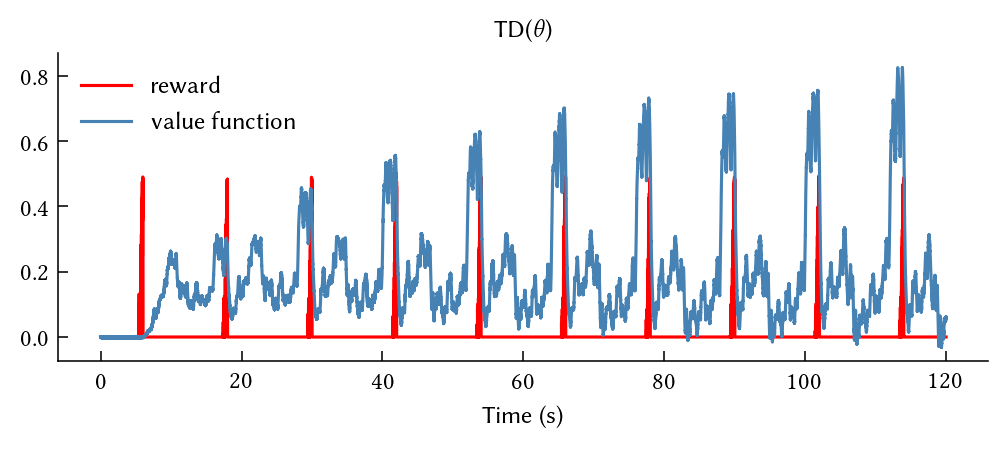

In [12]:
plt.figure(figsize=(6,2))
plt.plot(ts,rewards, label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')


plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')

Saving to tmaze_val.png


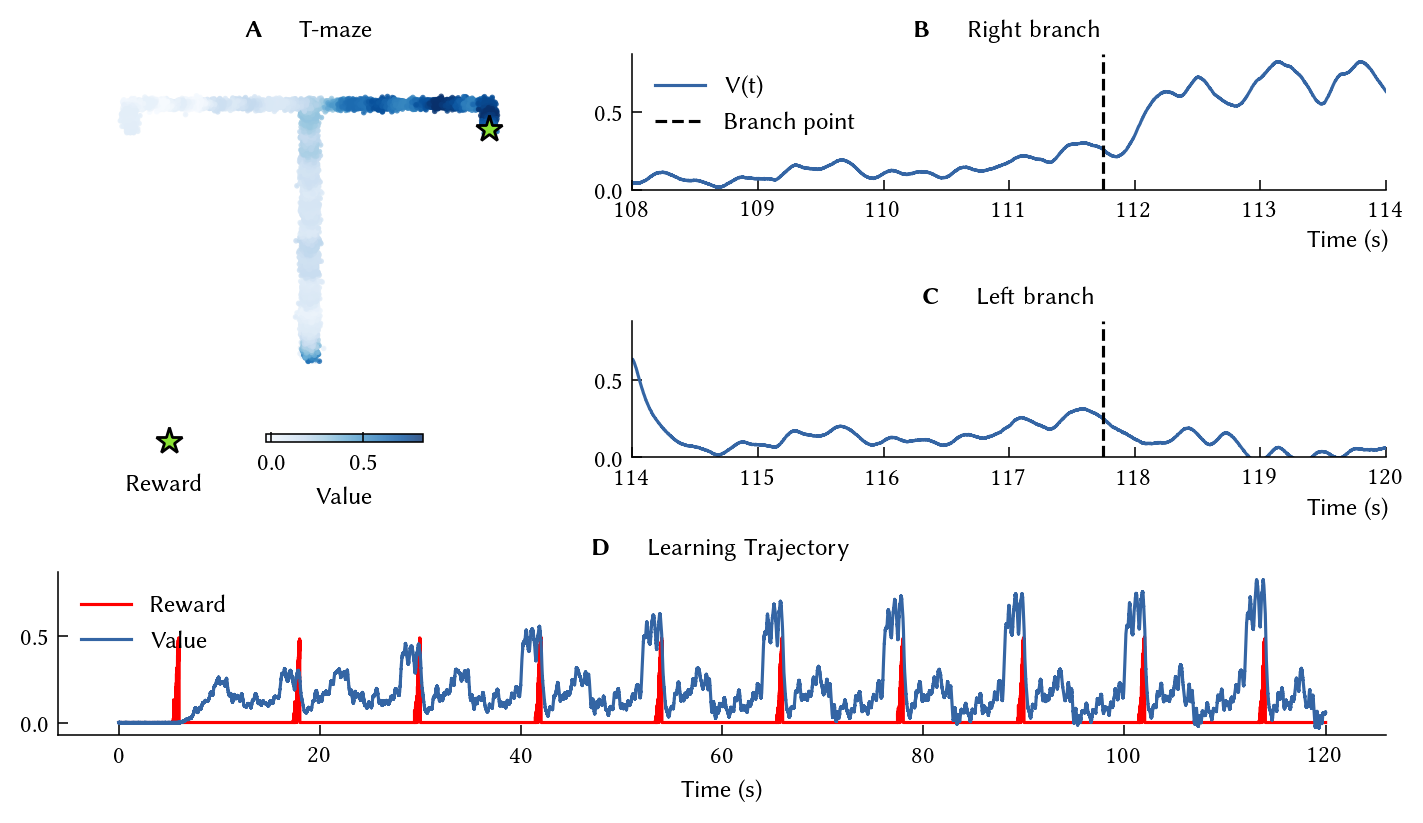

In [13]:
maxv = np.max(sim.data[V_p]) + 0.05
t_to_branch = dt*int(maze_h*n_steps/(0.5*maze_w + maze_h + maze_dh))



fig3 = plt.figure(figsize=(7,4), constrained_layout=True)
gs = fig3.add_gridspec(3,2, width_ratios=[1,1.5], height_ratios=[1,1,1.2])
f3_ax1 = fig3.add_subplot(gs[:2, 0])
f3_ax2 = fig3.add_subplot(gs[0,1])
f3_ax3 = fig3.add_subplot(gs[1, 1])
f3_ax4 = fig3.add_subplot(gs[2,:])

ptss = f3_ax1.scatter(states[-2*n_steps:,0],
               states[-2*n_steps:,1],s=1,c=sim.data[V_p][-2*n_steps:], alpha=0.8,cmap='Blues')
f3_ax1.plot(maze_w/2,maze_h-maze_dh, '*', color=utils.greens[2],markersize=10,markeredgecolor='k',label=' ')
f3_ax1.set_ylim([-2, maze_h+1])
f3_ax1.set_xlim([-maze_w/2 - 1, maze_w/2+1])
fig3.text(0.11, 0.4, "Reward", va="baseline", ha="center")
f3_ax1.set_title('\\textbf{A} $\quad$ T-maze  $\quad$')
f3_ax1.legend(loc=[0.15,-0.02])
cax = f3_ax1.inset_axes([0.2, 0.1, 0.4, 0.2])
fig.colorbar(ptss, ax=cax, location='bottom',label='Value')
f3_ax1.axis('off')
cax.axis('off')


f3_ax2.set_title('\\textbf{B} $\quad$ Right branch  $\quad$')
f3_ax2.plot(ts[-2*n_steps:-n_steps], sim.data[V_p][-2*n_steps:-n_steps], label='V(t)', color=utils.blues[1])
f3_ax2.vlines(T - 2*t_trial + t_to_branch, 0,maxv,linestyle='--',color='k',label='Branch point')
f3_ax2.set_ylim([0,maxv])
f3_ax2.set_xlim([T - 2*t_trial,T - t_trial])
f3_ax2.legend(loc='upper left')
label = f3_ax2.set_xlabel('Time (s)', fontsize = 9)
f3_ax2.xaxis.set_label_coords(0.95, -0.3)

f3_ax3.set_title('\\textbf{C} $\quad$ Left branch  $\quad$')
f3_ax3.plot(ts[-n_steps:], sim.data[V_p][-n_steps:], label='Value', color=utils.blues[1])
f3_ax3.vlines(T - t_trial + t_to_branch, 0,maxv,linestyle='--',color='k',label='Branch point')
f3_ax3.set_ylim([0,maxv])
f3_ax3.set_xlim([T - t_trial,T ])
label = f3_ax3.set_xlabel('Time (s)', fontsize = 9)
f3_ax3.xaxis.set_label_coords(0.95, -0.3)


f3_ax4.plot(ts,rewards, label='Reward', color='red')
f3_ax4.plot(ts, sim.data[V_p], color=utils.blues[1], label='Value')
f3_ax4.legend()
f3_ax4.set_xlabel('Time (s)')
f3_ax4.set_title('\\textbf{D} $\quad$ Learning Trajectory  $\quad$')
# utils.save(fig3,'tmaze_val.png')